In [1]:
from lightgbm import Dataset
from lightgbm import LGBMClassifier
from lightgbm import train
from matplotlib.pyplot import plot
from numpy import ndarray
from pandas import DataFrame
from pandas import read_csv
from pandas import Series
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
train_df = read_csv('../input/spaceship-titanic/train.csv')
print(train_df.columns.tolist())

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']


In [3]:
def prepare(input_df: DataFrame) -> ndarray:
    result_df = input_df.drop(columns=['PassengerId', 'Name', 'Transported'], errors='ignore').copy(deep=True)
    result_df['Cabin_Deck'] = result_df['Cabin'].apply(func=lambda x: 'Unknown' if isinstance(x, float) else x.split('/')[0])
    result_df['Cabin_Side'] = result_df['Cabin'].apply(func=lambda x: 'Unknown' if isinstance(x, float) else x.split('/')[2])
    columns = ['CryoSleep', 'Destination', 'HomePlanet', 'VIP', 'Cabin_Deck', 'Cabin_Side']
    for column in columns:
        result_df[column] = LabelEncoder().fit_transform(y=result_df[column])
    # todo do something with Cabin
    result_df = result_df.drop(columns=['Cabin'])
    return result_df.columns, result_df.values

# get the labels
y = train_df['Transported'].values
out_columns, x = prepare(input_df=train_df)

# split
random_state = 1
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state, stratify=y)
train_data = Dataset(x, label=y) #, categorical_feature='auto')
test_data = Dataset(x_test, label=y_test)

In [4]:
model = LGBMClassifier(
    boosting_type='gbdt', 
    class_weight=None, 
    colsample_bytree=1.0, 
    importance_type=['gain', 'split'][1],
    learning_rate = 0.01,
    max_depth=-1,  
    min_child_weight=0.001, 
    min_child_samples=20, 
    min_split_gain=0.0, 
    n_estimators=100, 
    n_jobs=None, 
    num_iterations=500,
    num_leaves=31,# was 31
    objective=None, 
    random_state=random_state, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    subsample_for_bin=200000, 
    subsample=1.0, 
    subsample_freq=0, 
)
model.fit(X=x, y=y, eval_set=(x_test, y_test))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's binary_logloss: 0.688951
[2]	valid_0's binary_logloss: 0.684863
[3]	valid_0's binary_logloss: 0.680875
[4]	valid_0's binary_logloss: 0.67695
[5]	valid_0's binary_logloss: 0.67312
[6]	valid_0's binary_logloss: 0.66938
[7]	valid_0's binary_logloss: 0.665685
[8]	valid_0's binary_logloss: 0.662094
[9]	valid_0's binary_logloss: 0.658561
[10]	valid_0's binary_logloss: 0.655113
[11]	valid_0's binary_logloss: 0.651676
[12]	valid_0's binary_logloss: 0.648306
[13]	valid_0's binary_logloss: 0.645004
[14]	valid_0's binary_logloss: 0.641799
[15]	valid_0's binary_logloss: 0.638646
[16]	valid_0's binary_logloss: 0.635522
[17]	valid_0's binary_logloss: 0.632487
[18]	valid_0's binary_logloss: 0.629476
[19]	valid_0's binary_logloss: 0.626533
[20]	valid_0's binary_logloss: 0.623594
[21]	valid_0's binary_logloss: 0.620793
[22]	valid_0's binary_logloss: 0.617996
[23]	valid_0's binary_logloss: 0.615252
[24]	valid_0's binary_logloss: 0.612581
[25]	valid_0's binary_logloss: 0.609886
[26]	valid_0

LGBMClassifier(learning_rate=0.01, n_jobs=None, num_iterations=500,
               random_state=1)

In [5]:
print(model.best_iteration_)
print(model.best_score_)
print(model.booster_)
print(model.classes_)
print(model.feature_name_)
print(model.n_classes_)
# print(model.n_estimators_)
print(model.n_features_)
print(model.n_features_in_)
# print(model.n_iter_)
print(model.objective_)


None
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('binary_logloss', 0.41300776608546413)])})
[False  True]
['Column_0', 'Column_1', 'Column_2', 'Column_3', 'Column_4', 'Column_5', 'Column_6', 'Column_7', 'Column_8', 'Column_9', 'Column_10', 'Column_11']
2
12
12
binary


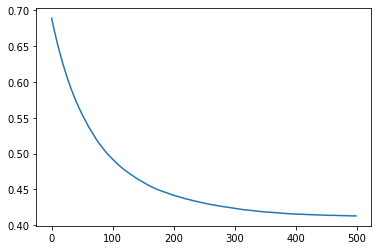

In [6]:
plot(model.evals_result_['valid_0']['binary_logloss'])

<AxesSubplot:>

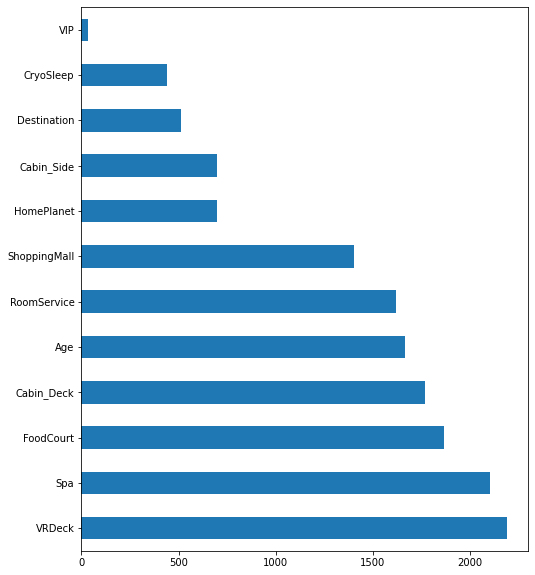

In [7]:
importance = Series(model.feature_importances_, index=out_columns)
importance.nlargest(30).plot(kind='barh', figsize=(8,10))

In [8]:
submission_df = read_csv('../input/spaceship-titanic/test.csv')
ids = submission_df['PassengerId'].values
submission_columns, submission_data = prepare(input_df=submission_df)
output_df = DataFrame({'PassengerId': ids, 'Transported': model.predict(submission_data) > 0.5})
output_df.to_csv('submission.csv', index=False)

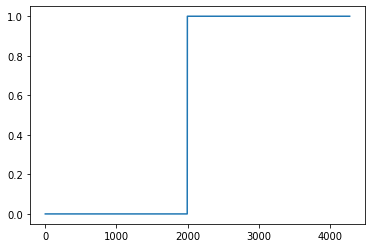

In [9]:
y_pred = model.predict(submission_data)
plot(sorted(y_pred.tolist()), )